In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [18]:
# предварительное исследование
path = "/kaggle/input/butterflies-classification/train_butterflies/train_split"
classes = sorted([d for d in os.listdir(path)])
# print(classes)

total = 0
balance_ = dict()
resolutions = set()

for class_ in classes:
    class_path = os.path.join(path, class_)
    balance_[class_] = 0
    class_images = [_ for _ in os.listdir(class_path)]

    for image in class_images:
        img_path = os.path.join(class_path, image)
        total += 1
        balance_[class_] += 1
        with Image.open(img_path) as img:
            width, height = img.size
            resolutions.add((width, height))

balance = sorted(balance_.items(), key=lambda item: item[1])
print("Всего изображений", total) # 4955
print("Разрешение:", resolutions) # 224 * 224 

Всего изображений 4955
Разрешение: {(224, 224)}


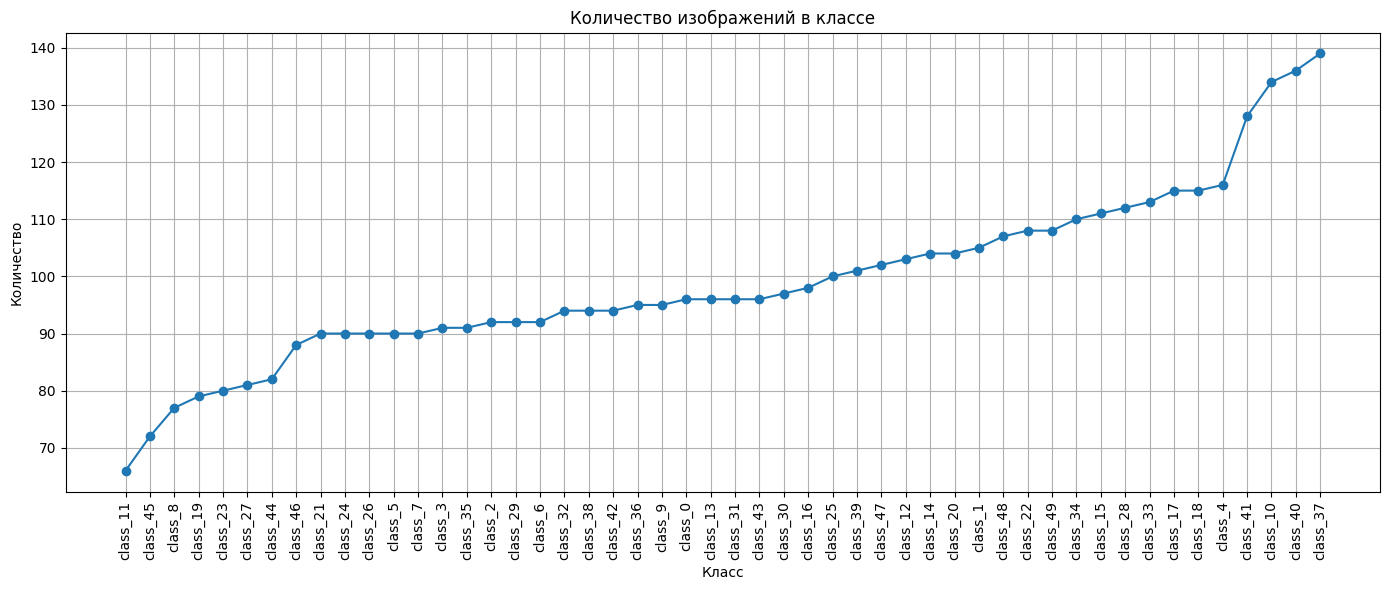

In [19]:
classes = [item[0] for item in balance]
values = [item[1] for item in balance]

plt.figure(figsize=(14, 6))
plt.plot(classes, values, marker='o')
plt.xticks(rotation=90)
plt.title('Количество изображений в классе')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# преобразование для аугментации
import random
from torchvision import transforms

max_balance = max([item[1] for item in balance])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.8),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.1),
    transforms.RandomAdjustSharpness(1.5, p=0.3),
    transforms.ToTensor(),
])

val_transform = transforms.ToTensor()

In [21]:
# подготовка данных для обучения

from torch.utils.data import Dataset
import torchvision.transforms.v2 as tfs
import torch.utils.data as data

class ButterflyDataset(Dataset):
    def __init__(self, transform=None):

        self.root_dir = "/kaggle/input/butterflies/train_butterflies/"
        self.transform = transform

        self.samples = []  # (path, class_idx)
        self.class_to_idx = {f'class_{i}': i for i in range(50)}

        class_names = self.class_to_idx.keys()

        for idx, class_name in enumerate(class_names):
            class_path = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            self.class_to_idx[class_name] = idx

            for fname in os.listdir(class_path):
                fpath = os.path.join(class_path, fname)
                if os.path.isfile(fpath) and fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((fpath, idx))

        self.len = len(self.samples)

    def __getitem__(self, index):
        img_path, label = self.samples[index]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return self.len

d_train = ButterflyDataset(transform=tfs.ToTensor())
print(len(d_train))
d_train[0]

4955


(tensor([[[0.1843, 0.1843, 0.1922,  ..., 0.4000, 0.3647, 0.3490],
          [0.2000, 0.2000, 0.2039,  ..., 0.4353, 0.4000, 0.3765],
          [0.2157, 0.2157, 0.2235,  ..., 0.4784, 0.4392, 0.4078],
          ...,
          [0.1098, 0.0588, 0.0784,  ..., 0.7569, 0.5922, 0.5686],
          [0.2627, 0.0941, 0.0902,  ..., 0.6353, 0.5922, 0.5765],
          [0.5294, 0.2353, 0.1333,  ..., 0.6157, 0.5922, 0.5725]],
 
         [[0.2863, 0.2863, 0.2941,  ..., 0.4431, 0.4275, 0.4196],
          [0.3020, 0.3020, 0.3059,  ..., 0.4784, 0.4510, 0.4392],
          [0.3176, 0.3216, 0.3294,  ..., 0.5176, 0.4863, 0.4588],
          ...,
          [0.0902, 0.0392, 0.0588,  ..., 0.6863, 0.5137, 0.4902],
          [0.2353, 0.0745, 0.0706,  ..., 0.5569, 0.5176, 0.5020],
          [0.5020, 0.2078, 0.1137,  ..., 0.5294, 0.5176, 0.4980]],
 
         [[0.1020, 0.1020, 0.1098,  ..., 0.1725, 0.1412, 0.1216],
          [0.1176, 0.1137, 0.1176,  ..., 0.2078, 0.1686, 0.1451],
          [0.1294, 0.1216, 0.1294,  ...,

In [22]:
d_train, d_val = data.random_split(d_train, [0.7, 0.3])
train_data = data.DataLoader(d_train, batch_size=16, shuffle=True, drop_last=True)
train_data_val = data.DataLoader(d_val, batch_size=1, shuffle=False)

In [23]:
# модель
import torch.nn as nn

class BasicBlock1(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
        )
        self.skip = nn.Sequential(
            nn.Conv2d(64, 128, 1, stride=2, bias=False),
            nn.BatchNorm2d(128)
        )

    def forward(self, x):
        return (self.skip(x) + self.block(x)).relu()
    
class BasicBlock2(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
        )

    def forward(self, x):
        return (x + self.block(x)).relu()

model = nn.Sequential(
    nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False),
    nn.BatchNorm2d(64),
    nn.MaxPool2d((3,3), stride=2, padding=1),
    BasicBlock1(),
    BasicBlock2(),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(128, 50)
)

model = model.to(device)

In [24]:
%%time
import torch.optim as optim
from tqdm import tqdm

model.train()
opt = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0.001)
loss_func = nn.CrossEntropyLoss()
losses = []
accuracies = []
epochs = 70
max_accuracy = 0


for _e in range(epochs):
    loss_mean = 0
    lm_count = 0

    # обучение
    train_tqdm = tqdm(train_data, leave=True)
    for x_train, y_train in train_tqdm:
        model.train()
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        predict = model(x_train)
        loss = loss_func(predict, y_train)
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}")

    # валидация
    model.eval()
    with torch.no_grad():
        right, amount = 0, 0
        for x_val, y_val in train_data_val:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            amount += 1
            outputs = model(x_val)
            right += (outputs.argmax().item() == y_val.item())

    acc = right / amount
    print(f"After {_e+1} epochs validation accuracy = {acc}")
    accuracies.append(acc)
    losses.append(loss_mean)

    if acc > max_accuracy:
        max_accuracy = acc
        torch.save(model.state_dict(), 'first_model.pth')        


model.eval()

Epoch [1/70], loss_mean=3.187: 100%|██████████| 216/216 [00:09<00:00, 23.95it/s]


After 1 epochs validation accuracy = 0.2018842530282638


Epoch [2/70], loss_mean=2.633: 100%|██████████| 216/216 [00:09<00:00, 23.30it/s]


After 2 epochs validation accuracy = 0.26850605652759085


Epoch [3/70], loss_mean=2.342: 100%|██████████| 216/216 [00:09<00:00, 22.93it/s]


After 3 epochs validation accuracy = 0.4104979811574697


Epoch [4/70], loss_mean=2.139: 100%|██████████| 216/216 [00:08<00:00, 24.38it/s]


After 4 epochs validation accuracy = 0.382907133243607


Epoch [5/70], loss_mean=1.934: 100%|██████████| 216/216 [00:08<00:00, 24.36it/s]


After 5 epochs validation accuracy = 0.3842530282637954


Epoch [6/70], loss_mean=1.831: 100%|██████████| 216/216 [00:09<00:00, 23.63it/s]


After 6 epochs validation accuracy = 0.42193808882907136


Epoch [7/70], loss_mean=1.692: 100%|██████████| 216/216 [00:09<00:00, 22.73it/s]


After 7 epochs validation accuracy = 0.2604306864064603


Epoch [8/70], loss_mean=1.548: 100%|██████████| 216/216 [00:09<00:00, 23.77it/s]


After 8 epochs validation accuracy = 0.4851951547779273


Epoch [9/70], loss_mean=1.443: 100%|██████████| 216/216 [00:09<00:00, 23.62it/s]


After 9 epochs validation accuracy = 0.5376850605652759


Epoch [10/70], loss_mean=1.372: 100%|██████████| 216/216 [00:08<00:00, 24.03it/s]


After 10 epochs validation accuracy = 0.4313593539703903


Epoch [11/70], loss_mean=1.243: 100%|██████████| 216/216 [00:09<00:00, 23.52it/s]


After 11 epochs validation accuracy = 0.6231493943472409


Epoch [12/70], loss_mean=1.199: 100%|██████████| 216/216 [00:09<00:00, 22.78it/s]


After 12 epochs validation accuracy = 0.21130551816958276


Epoch [13/70], loss_mean=1.115: 100%|██████████| 216/216 [00:09<00:00, 23.48it/s]


After 13 epochs validation accuracy = 0.4878869448183042


Epoch [14/70], loss_mean=1.053: 100%|██████████| 216/216 [00:09<00:00, 23.99it/s]


After 14 epochs validation accuracy = 0.5632570659488559


Epoch [15/70], loss_mean=0.998: 100%|██████████| 216/216 [00:09<00:00, 23.70it/s]


After 15 epochs validation accuracy = 0.3465679676985195


Epoch [16/70], loss_mean=0.956: 100%|██████████| 216/216 [00:09<00:00, 22.94it/s]


After 16 epochs validation accuracy = 0.6049798115746972


Epoch [17/70], loss_mean=0.911: 100%|██████████| 216/216 [00:09<00:00, 23.49it/s]


After 17 epochs validation accuracy = 0.6285329744279946


Epoch [18/70], loss_mean=0.853: 100%|██████████| 216/216 [00:08<00:00, 24.09it/s]


After 18 epochs validation accuracy = 0.5975773889636609


Epoch [19/70], loss_mean=0.824: 100%|██████████| 216/216 [00:08<00:00, 24.23it/s]


After 19 epochs validation accuracy = 0.6258411843876177


Epoch [20/70], loss_mean=0.791: 100%|██████████| 216/216 [00:09<00:00, 23.47it/s]


After 20 epochs validation accuracy = 0.6244952893674294


Epoch [21/70], loss_mean=0.742: 100%|██████████| 216/216 [00:09<00:00, 23.26it/s]


After 21 epochs validation accuracy = 0.693135935397039


Epoch [22/70], loss_mean=0.693: 100%|██████████| 216/216 [00:08<00:00, 24.44it/s]


After 22 epochs validation accuracy = 0.6534320323014805


Epoch [23/70], loss_mean=0.695: 100%|██████████| 216/216 [00:09<00:00, 23.57it/s]


After 23 epochs validation accuracy = 0.6238223418573351


Epoch [24/70], loss_mean=0.644: 100%|██████████| 216/216 [00:08<00:00, 24.26it/s]


After 24 epochs validation accuracy = 0.7415881561238223


Epoch [25/70], loss_mean=0.588: 100%|██████████| 216/216 [00:09<00:00, 23.37it/s]


After 25 epochs validation accuracy = 0.7207267833109018


Epoch [26/70], loss_mean=0.576: 100%|██████████| 216/216 [00:09<00:00, 23.97it/s]


After 26 epochs validation accuracy = 0.5403768506056528


Epoch [27/70], loss_mean=0.541: 100%|██████████| 216/216 [00:08<00:00, 24.24it/s]


After 27 epochs validation accuracy = 0.566621803499327


Epoch [28/70], loss_mean=0.527: 100%|██████████| 216/216 [00:09<00:00, 23.66it/s]


After 28 epochs validation accuracy = 0.522207267833109


Epoch [29/70], loss_mean=0.476: 100%|██████████| 216/216 [00:09<00:00, 23.74it/s]


After 29 epochs validation accuracy = 0.7086137281292059


Epoch [30/70], loss_mean=0.470: 100%|██████████| 216/216 [00:09<00:00, 23.59it/s]


After 30 epochs validation accuracy = 0.7052489905787349


Epoch [31/70], loss_mean=0.437: 100%|██████████| 216/216 [00:08<00:00, 24.12it/s]


After 31 epochs validation accuracy = 0.7220726783310901


Epoch [32/70], loss_mean=0.441: 100%|██████████| 216/216 [00:08<00:00, 24.10it/s]


After 32 epochs validation accuracy = 0.5901749663526245


Epoch [33/70], loss_mean=0.423: 100%|██████████| 216/216 [00:08<00:00, 24.07it/s]


After 33 epochs validation accuracy = 0.5935397039030955


Epoch [34/70], loss_mean=0.400: 100%|██████████| 216/216 [00:09<00:00, 23.87it/s]


After 34 epochs validation accuracy = 0.7644683714670256


Epoch [35/70], loss_mean=0.381: 100%|██████████| 216/216 [00:09<00:00, 22.90it/s]


After 35 epochs validation accuracy = 0.765814266487214


Epoch [36/70], loss_mean=0.366: 100%|██████████| 216/216 [00:08<00:00, 24.48it/s]


After 36 epochs validation accuracy = 0.7314939434724091


Epoch [37/70], loss_mean=0.333: 100%|██████████| 216/216 [00:09<00:00, 23.62it/s]


After 37 epochs validation accuracy = 0.7139973082099597


Epoch [38/70], loss_mean=0.322: 100%|██████████| 216/216 [00:08<00:00, 24.03it/s]


After 38 epochs validation accuracy = 0.765814266487214


Epoch [39/70], loss_mean=0.333: 100%|██████████| 216/216 [00:09<00:00, 23.11it/s]


After 39 epochs validation accuracy = 0.7880215343203231


Epoch [40/70], loss_mean=0.295: 100%|██████████| 216/216 [00:09<00:00, 23.44it/s]


After 40 epochs validation accuracy = 0.7543741588156124


Epoch [41/70], loss_mean=0.286: 100%|██████████| 216/216 [00:09<00:00, 22.75it/s]


After 41 epochs validation accuracy = 0.5841184387617766


Epoch [42/70], loss_mean=0.230: 100%|██████████| 216/216 [00:09<00:00, 22.67it/s]


After 42 epochs validation accuracy = 0.8028263795423957


Epoch [43/70], loss_mean=0.254: 100%|██████████| 216/216 [00:09<00:00, 22.89it/s]


After 43 epochs validation accuracy = 0.7456258411843876


Epoch [44/70], loss_mean=0.246: 100%|██████████| 216/216 [00:09<00:00, 23.27it/s]


After 44 epochs validation accuracy = 0.7113055181695828


Epoch [45/70], loss_mean=0.232: 100%|██████████| 216/216 [00:09<00:00, 23.75it/s]


After 45 epochs validation accuracy = 0.8028263795423957


Epoch [46/70], loss_mean=0.216: 100%|██████████| 216/216 [00:09<00:00, 23.02it/s]


After 46 epochs validation accuracy = 0.7873485868102288


Epoch [47/70], loss_mean=0.192: 100%|██████████| 216/216 [00:10<00:00, 20.92it/s]


After 47 epochs validation accuracy = 0.7732166890982504


Epoch [48/70], loss_mean=0.188: 100%|██████████| 216/216 [00:09<00:00, 22.37it/s]


After 48 epochs validation accuracy = 0.8001345895020189


Epoch [49/70], loss_mean=0.202: 100%|██████████| 216/216 [00:09<00:00, 21.79it/s]


After 49 epochs validation accuracy = 0.7483176312247645


Epoch [50/70], loss_mean=0.213: 100%|██████████| 216/216 [00:09<00:00, 23.47it/s]


After 50 epochs validation accuracy = 0.7537012113055181


Epoch [51/70], loss_mean=0.201: 100%|██████████| 216/216 [00:09<00:00, 22.91it/s]


After 51 epochs validation accuracy = 0.8142664872139973


Epoch [52/70], loss_mean=0.176: 100%|██████████| 216/216 [00:08<00:00, 24.33it/s]


After 52 epochs validation accuracy = 0.6655450874831763


Epoch [53/70], loss_mean=0.152: 100%|██████████| 216/216 [00:09<00:00, 24.00it/s]


After 53 epochs validation accuracy = 0.7994616419919246


Epoch [54/70], loss_mean=0.149: 100%|██████████| 216/216 [00:08<00:00, 24.05it/s]


After 54 epochs validation accuracy = 0.7597577388963661


Epoch [55/70], loss_mean=0.180: 100%|██████████| 216/216 [00:09<00:00, 23.31it/s]


After 55 epochs validation accuracy = 0.6635262449528937


Epoch [56/70], loss_mean=0.136: 100%|██████████| 216/216 [00:09<00:00, 23.30it/s]


After 56 epochs validation accuracy = 0.715343203230148


Epoch [57/70], loss_mean=0.146: 100%|██████████| 216/216 [00:08<00:00, 24.05it/s]


After 57 epochs validation accuracy = 0.7860026917900403


Epoch [58/70], loss_mean=0.141: 100%|██████████| 216/216 [00:09<00:00, 23.95it/s]


After 58 epochs validation accuracy = 0.7456258411843876


Epoch [59/70], loss_mean=0.145: 100%|██████████| 216/216 [00:08<00:00, 24.29it/s]


After 59 epochs validation accuracy = 0.7590847913862718


Epoch [60/70], loss_mean=0.105: 100%|██████████| 216/216 [00:09<00:00, 23.60it/s]


After 60 epochs validation accuracy = 0.7873485868102288


Epoch [61/70], loss_mean=0.103: 100%|██████████| 216/216 [00:09<00:00, 23.90it/s]


After 61 epochs validation accuracy = 0.7913862718707941


Epoch [62/70], loss_mean=0.099: 100%|██████████| 216/216 [00:09<00:00, 23.18it/s]


After 62 epochs validation accuracy = 0.7671601615074024


Epoch [63/70], loss_mean=0.129: 100%|██████████| 216/216 [00:09<00:00, 23.24it/s]


After 63 epochs validation accuracy = 0.7348586810228802


Epoch [64/70], loss_mean=0.117: 100%|██████████| 216/216 [00:09<00:00, 23.14it/s]


After 64 epochs validation accuracy = 0.7637954239569313


Epoch [65/70], loss_mean=0.121: 100%|██████████| 216/216 [00:09<00:00, 23.74it/s]


After 65 epochs validation accuracy = 0.8041722745625841


Epoch [66/70], loss_mean=0.101: 100%|██████████| 216/216 [00:09<00:00, 22.87it/s]


After 66 epochs validation accuracy = 0.8169582772543742


Epoch [67/70], loss_mean=0.104: 100%|██████████| 216/216 [00:09<00:00, 23.69it/s]


After 67 epochs validation accuracy = 0.730820995962315


Epoch [68/70], loss_mean=0.094: 100%|██████████| 216/216 [00:09<00:00, 23.76it/s]


After 68 epochs validation accuracy = 0.8109017496635262


Epoch [69/70], loss_mean=0.086: 100%|██████████| 216/216 [00:09<00:00, 23.56it/s]


After 69 epochs validation accuracy = 0.8129205921938089


Epoch [70/70], loss_mean=0.104: 100%|██████████| 216/216 [00:09<00:00, 23.80it/s]


After 70 epochs validation accuracy = 0.7853297442799462
CPU times: user 26min 50s, sys: 59 s, total: 27min 49s
Wall time: 15min 51s


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (3): BasicBlock1(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (skip): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (4): BasicBlock2(
    (block): Sequential(
      (0): Conv2d(128, 128, kernel_size

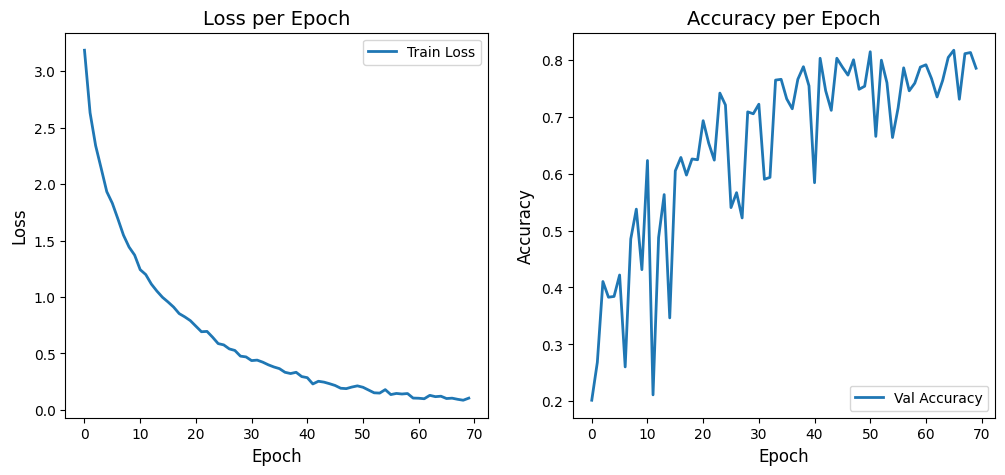

In [25]:
# график
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(losses, label='Train Loss', linewidth=2)
axes[0].set_title('Loss per Epoch', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)

axes[1].plot(accuracies, label='Val Accuracy', linewidth=2)
axes[1].set_title('Accuracy per Epoch', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(loc='lower right', fontsize=10)

plt.show()

In [27]:
%%time
with torch.no_grad():
    right, amount = 0, 0
    for x_val, y_val in train_data_val:
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        amount += 1
        outputs = model(x_val)
        right += (outputs.argmax().item() == y_val.item())

print(right/amount)

0.7853297442799462
CPU times: user 7.47 s, sys: 102 ms, total: 7.57 s
Wall time: 4.2 s


In [33]:
# попробуем другой подход - дообучить уже существующую модель

from torchvision.models import efficientnet_b3

model = efficientnet_b3(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 50)

for param in model.classifier[1].parameters():
    param.requires_grad = True

model = model.to(device)

model.train()
opt = optim.Adam(params=model.classifier[1].parameters(), lr=0.001, weight_decay=0.001)
loss_func = nn.CrossEntropyLoss()
losses = []
accuracies = []
epochs = 20
max_accuracy = 0


for _e in range(epochs):
    loss_mean = 0
    lm_count = 0

    # обучение
    train_tqdm = tqdm(train_data, leave=True)
    for x_train, y_train in train_tqdm:
        model.train()
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        predict = model(x_train)
        loss = loss_func(predict, y_train)
        
        opt.zero_grad()
        loss.backward()
        opt.step()        

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}")

    # валидация
    model.eval()
    with torch.no_grad():
        right, amount = 0, 0
        for x_val, y_val in train_data_val:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            amount += 1
            outputs = model(x_val)
            right += (outputs.argmax().item() == y_val.item())

    acc = right / amount
    print(f"After {_e+1} epochs validation accuracy = {acc}")
    accuracies.append(acc)
    losses.append(loss_mean)

    if acc > max_accuracy:
        max_accuracy = acc
        torch.save(model.state_dict(), 'second_model.pth')

Epoch [1/5], loss_mean=2.574: 100%|██████████| 216/216 [00:13<00:00, 16.25it/s]


After 1 epochs validation accuracy = 0.8082099596231493


Epoch [2/5], loss_mean=1.214: 100%|██████████| 216/216 [00:12<00:00, 16.73it/s]


After 2 epochs validation accuracy = 0.8445491251682369


Epoch [3/5], loss_mean=0.843: 100%|██████████| 216/216 [00:12<00:00, 16.88it/s]


After 3 epochs validation accuracy = 0.8553162853297442


Epoch [4/5], loss_mean=0.657: 100%|██████████| 216/216 [00:12<00:00, 16.81it/s]


After 4 epochs validation accuracy = 0.8553162853297442


Epoch [5/5], loss_mean=0.575: 100%|██████████| 216/216 [00:12<00:00, 16.72it/s]


After 5 epochs validation accuracy = 0.8633916554508748


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
# график
model.eval()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(losses, label='Train Loss', linewidth=2)
axes[0].set_title('Loss per Epoch', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)

axes[1].plot(accuracies, label='Val Accuracy', linewidth=2)
axes[1].set_title('Accuracy per Epoch', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(loc='lower right', fontsize=10)

plt.show()